# Neural Network Solution

В данном исследовании попробуем предсказывать метки классов с помощью нейросетей, а именно с помощью рекуррентной нейросети

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim, nn

from sklearn.model_selection import train_test_split
from sklearn import metrics

import gensim.downloader

RND_STATE = 3010

In [2]:
torch.manual_seed(RND_STATE)
torch.cuda.manual_seed(RND_STATE)
np.random.seed(RND_STATE)
random.seed(RND_STATE)
torch.backends.cudnn.deterministic = True

## Data loading

In [3]:
train_data = pd.read_csv('data/c_train.csv')
test_data = pd.read_csv('data/c_test.csv')

In [4]:
train_data.head(3)

,cleaned,is_fake
0,москвич владимир клутин приходить счет вмешате...,1
1,агент кокорин называть езда встречок житейский...,0
2,госдума рассматривать возможность введение сек...,1


In [5]:
test_data.head(3)

,cleaned,is_fake
0,роскомнадзор представлять реестр сочетание цве...,0
1,ночь минск президентский горе беларашмор пик д...,0
2,бывший спичрайтер юрий лоза рассказывать трудн...,0


Создадим обёртку набора данных для torch, а также загрузчик данных, который понадобится при обучении

In [6]:
class TextDataset(Dataset):
    """Proxy between pandas DataFrame and torch tensors"""
    def __init__(self, pd_df: pd.DataFrame, vocabulary: dict):
        self.df = pd_df.copy()
        
        self.word_to_idx = vocabulary
        self.df['cleaned'] = self.df['cleaned'].apply(lambda x: x.split(' '))
        
        self.df['cleaned'] = self.df['cleaned'].apply(lambda sentence: [self.word_to_idx.get(word, 0) for word in sentence])
        # Sentence max length
        self.max_len = max(self.df.cleaned.apply(len))
        
    def __getitem__(self, idx: int):
        """Returns x_values, y_value and sentence length"""
        res_tensor = torch.zeros(self.max_len, dtype=torch.long)
        word_lst = self.df.iloc[idx]['cleaned']
        
        res_tensor[:len(word_lst)] = torch.Tensor(word_lst)
        
        return res_tensor, self.df.iloc[idx]['is_fake'], len(word_lst)
    
    def __len__(self):
        return self.df.shape[0]

Разобьём данные на тренировочные и валидационные также как и раньше, зафиксировав random seed

In [7]:
train_ds, val_ds = train_test_split(train_data, test_size=0.2, random_state=RND_STATE, stratify=train_data.is_fake)

In [8]:
train_ds.head()

,cleaned,is_fake
726,европа отступать банановый фронт,0
2660,роскомнадзор проверять пропаганда гомосексуали...,1
7,россиянин обхитрить рост цена,0
1733,интер рао выкупать огк норникель,0
4658,главврач нок рб тимановский весь признак вялот...,1


## Model

Создадим нейросеть на основе LSTM

In [9]:
class LSTMPredictor(nn.Module):
    def __init__(self, vocab_size: int, word_embed_dim: int, lstm_hid_layer_size: int, layers_count:int = 1, 
                 dropout_p: float = 0.5, bidirectional: bool = False):
        super().__init__()
        
        self.bidirectional = bidirectional
        self.emb = nn.Embedding(vocab_size + 1, word_embed_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(word_embed_dim, lstm_hid_layer_size, layers_count, 
                                  bidirectional=bidirectional, batch_first=True)
        
        self.fc = nn.Linear(2 * lstm_hid_layer_size if bidirectional else lstm_hid_layer_size, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_p)
        
        
    def forward(self, x_batch, seq_len):
        embeded = self.emb(x_batch)
        
        packed = nn.utils.rnn.pack_padded_sequence(embeded, seq_len, batch_first=True, enforce_sorted=False)
        
        _, (h, c) = self.lstm(packed)
        # Prediction on last word
        drop_pred = self.dropout(h[-1])
        
        pred = self.fc(torch.cat((h[-2,:,:], h[-1,:,:]), dim=1)) if self.bidirectional else self.fc(drop_pred)
        
        return self.sigmoid(pred)

## Training

Создадим функцию для тренировки нейросети

In [10]:
def compute_metric(model, loader, metric, threshold):
    # Exiting train mode
    model.eval()
    
    y_probs = np.array([])
    ground_truth = np.array([])
    
    for x, y, seq_len in loader:
        pred = model(x, seq_len).reshape(-1)
        
        y_probs = np.hstack((y_probs, pred.detach().numpy()))
        ground_truth = np.hstack((ground_truth, y.detach().numpy()))
        
    # Convertion from probabilities to class labels
    label_predictions = [1 if i >= threshold else 0 for i in y_probs]
    ground_truth = [int(i) for i in ground_truth]
        
    return metric(ground_truth, label_predictions)


def train_model(model, train_loader, val_loader, loss, metric, optimizer, scheduler=None, num_epochs=10, threshold=0.8):
    loss_history = list()
    train_metric_history = list()
    val_metric_history = list()
    
    for epoch_ind in range(num_epochs):
        # Entering train mode
        model.train()
        
        loss_accum = 0
        # Model will return probabilities
        y_probs = np.array([])
        ground_truth = np.array([])
        
        for i_step, (X, y, seq_len) in enumerate(train_loader, 1):
            pred = model(X, seq_len).reshape(-1)
            y = y.type(torch.FloatTensor)
            # Calculating loss
            loss_value = loss(pred, y)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()        
            
            loss_accum += loss_value
            
            y_probs = np.hstack((y_probs, pred.detach().numpy()))
            ground_truth = np.hstack((ground_truth, y.detach().numpy()))
        
        if scheduler is not None:
            scheduler.step()
        # Converting probabilities to class labels for calculating training metric
        label_predictions = [1 if i >= threshold else 0 for i in y_probs]
        ground_truth = [int(i) for i in ground_truth]
        
        loss_history.append(float(loss_accum / i_step))
        train_metric_history.append(metric(ground_truth, label_predictions))
        val_metric_history.append(compute_metric(model, val_loader, metric, threshold))
        
        print(f"Epoch #{epoch_ind + 1} -> Validation metric: {round(val_metric_history[-1], 5)}, " + \
              f"Train metric: {round(train_metric_history[-1], 5)}, Loss value: {round(loss_history[-1], 5)}")
            
    
    return loss_history, train_metric_history, val_metric_history

Создадим функцию для построения графиков с результатами обучения

In [11]:
def plot_results(loss_history, train_metric_history, val_metric_history):
    """Plots the results of training on two graphics(Loss and metric)"""
    plt.figure(figsize=(15, 30))
    
    x_vals = list(range(1, len(loss_history) + 1))
    
    plt.subplot(2, 1, 1)
    
    plt.plot(x_vals, loss_history)
    
    plt.title('График функции потерь')
    plt.xlabel('Эпоха')
    plt.ylabel('Значение функции потерь $L(x)$')
    
    plt.grid()
    
    plt.subplot(2, 1, 2)
    
    plt.plot(x_vals, train_metric_history, label='На тренировке')
    plt.plot(x_vals, val_metric_history, label='На валидации')
    
    plt.title('График метрики на тренировке')
    plt.xlabel('Эпоха')
    plt.ylabel('Значение метрики')
    
    plt.grid()
    plt.legend()

Для того чтобы проверить нашу модель после её обучения оставим x_valid как тестовую выборку, и сделаем новую валидационную выборку для нейросети. Если не сделать так, то при обучении мы можем переобучится на валидационную выборку и оценка модели на такой выборке будет уже не такой надёжной

In [12]:
nn_train_ds, nn_valid_ds = train_test_split(train_ds, test_size=0.15, random_state=RND_STATE, stratify=train_ds.is_fake)

Создаём словари для тренировки, которые нужны модели для построения векторов для слов

In [13]:
words_set = {word for sentence in nn_train_ds.cleaned for word in sentence.split(' ')}
train_vocabulary = {word: ind for ind, word in enumerate(words_set, 1)}

In [14]:
train_loader = DataLoader(TextDataset(nn_train_ds, train_vocabulary), batch_size=32, shuffle=True)
val_loader = DataLoader(TextDataset(nn_valid_ds, train_vocabulary), batch_size=32, shuffle=True)

После создания всех необходимых функций и подготовки данных приступим к тренировке

Epoch #1 -> Validation metric: 0.70847, Train metric: 0.50668, Loss value: 0.54866
Epoch #2 -> Validation metric: 0.73968, Train metric: 0.95705, Loss value: 0.09458
Epoch #3 -> Validation metric: 0.77313, Train metric: 0.99821, Loss value: 0.01419
Epoch #4 -> Validation metric: 0.7786, Train metric: 0.99974, Loss value: 0.00504
Epoch #5 -> Validation metric: 0.78402, Train metric: 1.0, Loss value: 0.00283
Epoch #6 -> Validation metric: 0.78402, Train metric: 1.0, Loss value: 0.00199
Epoch #7 -> Validation metric: 0.78107, Train metric: 1.0, Loss value: 0.00154
Epoch #8 -> Validation metric: 0.77876, Train metric: 1.0, Loss value: 0.00125
Epoch #9 -> Validation metric: 0.77941, Train metric: 1.0, Loss value: 0.00106
Epoch #10 -> Validation metric: 0.77827, Train metric: 1.0, Loss value: 0.00092


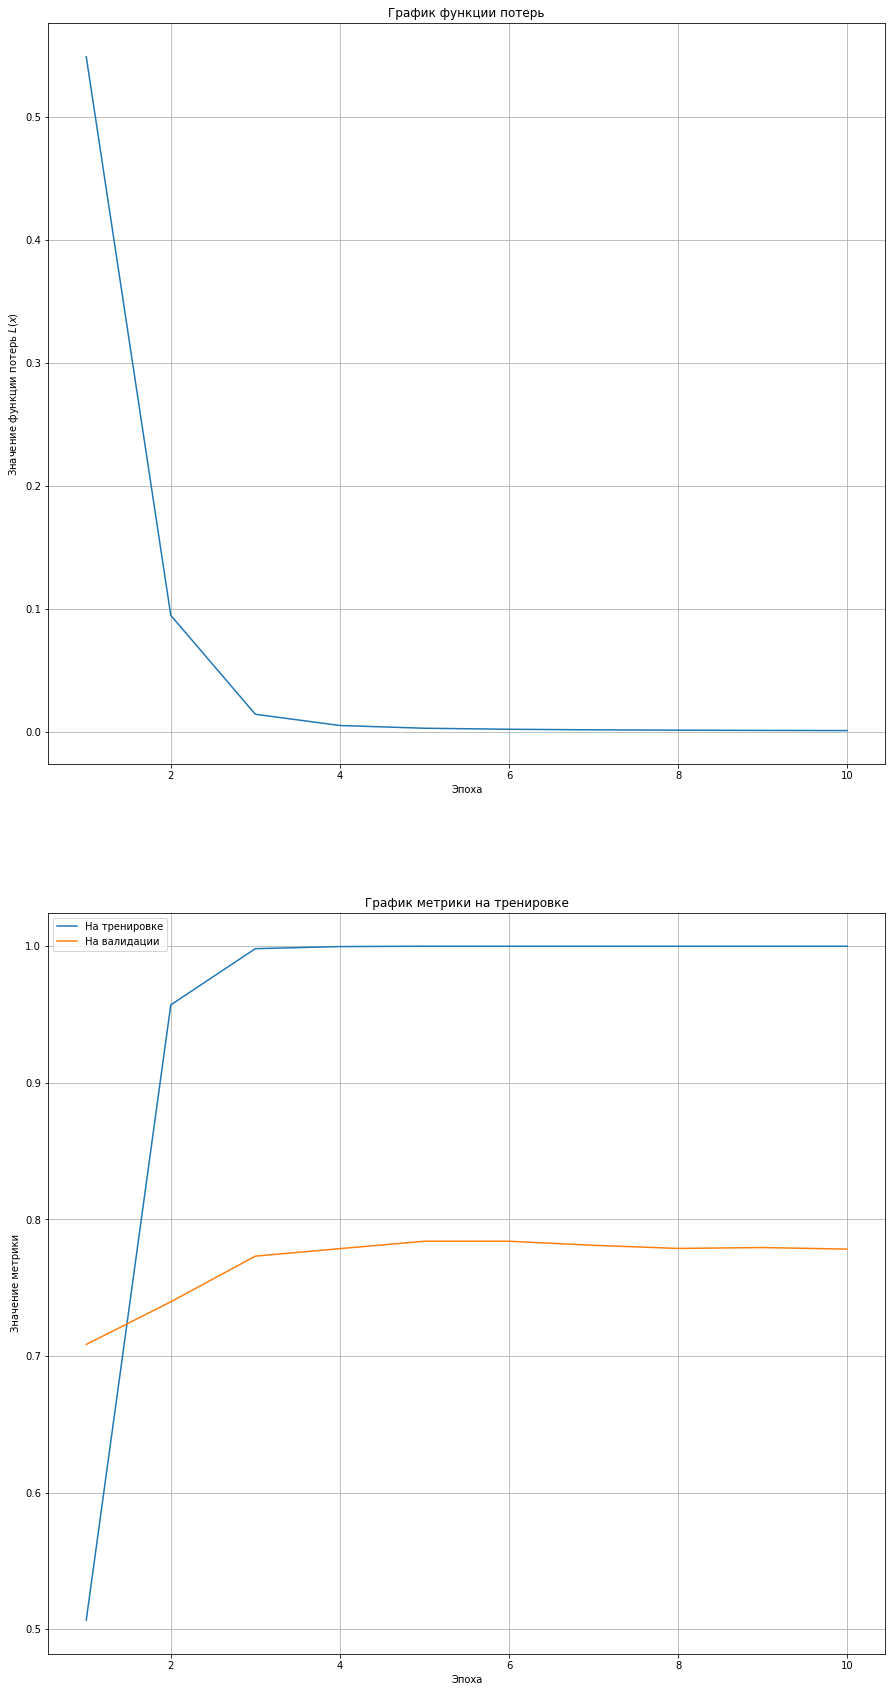

In [15]:
word_embed_dim = 100
lstm_hid_layer_size = 30
layers_count = 1
drop_p = 0.2


model = LSTMPredictor(len(train_vocabulary), word_embed_dim, lstm_hid_layer_size, layers_count, 
                      dropout_p=drop_p, bidirectional=True)

optimizer = optim.Adagrad(model.parameters(), lr=1e-1)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

loss = torch.nn.BCELoss()

plot_results(*train_model(model, train_loader, val_loader, loss, metrics.f1_score, optimizer,
                          scheduler=scheduler, threshold=0.75))

Отсюда видно, что модель очень сильно переобучается

## Word2Vec

Переведём слова в векторное представление с помощью предобученных embedding'ов

In [16]:
pret_vect = gensim.downloader.load('word2vec-ruscorpora-300')

In [17]:
pret_vect.key_to_index

{'весь_DET': 0,
 'человек_NOUN': 1,
 'мочь_VERB': 2,
 'год_NOUN': 3,
 'сказать_VERB': 4,
 'время_NOUN': 5,
 'говорить_VERB': 6,
 'становиться_VERB': 7,
 'знать_VERB': 8,
 'самый_DET': 9,
 'дело_NOUN': 10,
 'день_NOUN': 11,
 'жизнь_NOUN': 12,
 'рука_NOUN': 13,
 'очень_ADV': 14,
 'первый_ADJ': 15,
 'давать_VERB': 16,
 'новый_ADJ': 17,
 'слово_NOUN': 18,
 'иметь_VERB': 19,
 'большой_ADJ': 20,
 'идти_VERB': 21,
 'глаз_NOUN': 22,
 'место_NOUN': 23,
 'лицо_NOUN': 24,
 'видеть_VERB': 25,
 'хотеть_VERB': 26,
 'понимать_VERB': 27,
 'должный_ADJ': 28,
 'работа_NOUN': 29,
 'каждый_DET': 30,
 'друг_NOUN': 31,
 'голова_NOUN': 32,
 'дом_NOUN': 33,
 'оставаться_VERB': 34,
 'сторона_NOUN': 35,
 'начинать_VERB': 36,
 'думать_VERB': 37,
 'хорошо_ADV': 38,
 'жить_VERB': 39,
 'стоять_VERB': 40,
 'спрашивать_VERB': 41,
 'сделать_VERB': 42,
 'выходить_VERB': 43,
 'последний_ADJ': 44,
 'русский_ADJ': 45,
 'сила_NOUN': 46,
 'получать_VERB': 47,
 'какой-то_DET': 48,
 'хороший_ADJ': 49,
 'случай_NOUN': 50,
 'во

In [18]:
word_emb = {i[0].split('_')[0]: i[1] for i in pret_vect.key_to_index.items()}

In [19]:
word_emb

{'весь': 23388,
 'человек': 1,
 'мочь': 10647,
 'год': 3,
 'сказать': 4,
 'время': 5,
 'говорить': 6,
 'становиться': 7,
 'знать': 69459,
 'самый': 9,
 'дело': 10,
 'день': 11,
 'жизнь': 12,
 'рука': 13,
 'очень': 14,
 'первый': 15,
 'давать': 16,
 'новый': 17,
 'слово': 18,
 'иметь': 19,
 'большой': 20,
 'идти': 21,
 'глаз': 22,
 'место': 23,
 'лицо': 24,
 'видеть': 48065,
 'хотеть': 26,
 'понимать': 27,
 'должный': 28,
 'работа': 29,
 'каждый': 173108,
 'друг': 31,
 'голова': 32,
 'дом': 33,
 'оставаться': 34,
 'сторона': 35,
 'начинать': 36,
 'думать': 37,
 'хорошо': 4149,
 'жить': 57328,
 'стоять': 110366,
 'спрашивать': 41,
 'сделать': 42,
 'выходить': 43,
 'последний': 44,
 'русский': 1548,
 'сила': 46,
 'получать': 47,
 'какой-то': 48,
 'хороший': 49,
 'случай': 50,
 'вопрос': 51,
 'отвечать': 52,
 'россия': 53,
 'несколько': 607,
 'мир': 55,
 'город': 56,
 'делать': 57,
 'пойти': 58,
 'приходить': 59,
 'земля': 60,
 'принимать': 61,
 'часть': 62,
 'вид': 63,
 'ребенок': 64,
 'к

Посмотрим сколько из этих векторов подходят нам

In [20]:
words_ratio = sum([1 if i in word_emb else 0 for i in train_vocabulary.keys()]) / len(train_vocabulary)

print('Часть слов для которых имеется векторное представление:', round(words_ratio * 100, 2), '%')

Часть слов для которых имеется векторное представление: 90.01 %


Попробуем использовать векторное представление для слов, которые совпадают. Остальные будут иметь нулевой или случайный вектор. Проверим какая замена лучше работает

In [21]:
def get_emb_tensor_zeros(word_voc: dict, word_vec_voc: dict) -> torch.Tensor:
    """Converts word vocabulary and word vector dictionary 
       to Tensor of word vectors
       
       Args:
       
           word_voc: dictionary where word is key and index is value
           word_vec_voc: dictionary where word is key and numpy vector is value
       
       Returns: Tensor of vectors, Tensor shape is (word_voc_len, vector_len)
       
    """
    
    result = torch.Tensor().new_zeros(size=(len(word_voc) + 1, len(list(word_vec_voc.values())[0])))
    
    for word in word_voc:
        word_ind = word_voc[word]
        
        if word in word_vec_voc:
            result[word_ind] = torch.FloatTensor(word_vec_voc[word])
            
    return result

In [22]:
def get_emb_tensor_rand(word_voc: dict, word_vec_voc: dict) -> torch.Tensor:
    """Converts word vocabulary and word vector dictionary 
       to Tensor of word vectors
       
       Args:
       
           word_voc: dictionary where word is key and index is value
           word_vec_voc: dictionary where word is key and numpy vector is value
       
       Returns: Tensor of vectors, Tensor shape is (word_voc_len, vector_len)
       
    """
    
    result = torch.Tensor().new_zeros(size=(len(word_voc) + 1, len(list(word_vec_voc.values())[0])))
    
    for word in word_voc:
        word_ind = word_voc[word]
        
        result[word_ind] = torch.FloatTensor(word_vec_voc[word]) if word in word_vec_voc else torch.rand(result.shape[1])
            
    return result

In [23]:
train_word_emb = { word: pret_vect.vectors[word_emb[word]] for word in train_vocabulary if word in word_emb }

emb_tensor_zeros = get_emb_tensor_zeros(train_vocabulary, train_word_emb)

emb_tensor_rnd = get_emb_tensor_rand(train_vocabulary, train_word_emb)

Обновим модель, чтобы она использовала предобученные вектора в Embedding слое

In [24]:
class LSTMPredictorEmbd(nn.Module):
    """LSTM predictor with pretrained word embeddings"""
    def __init__(self, word_emb: torch.Tensor, lstm_hid_layer_size: int, layers_count:int = 1, 
                 dropout_p: float = 0.5, bidirectional: bool = False, freeze_emb: bool=True):
        super().__init__()
        
        self.bidirectional = bidirectional
        self.emb = nn.Embedding.from_pretrained(word_emb, freeze=freeze_emb)
        
        self.lstm = nn.LSTM(self.emb.embedding_dim, lstm_hid_layer_size, layers_count, 
                                  bidirectional=bidirectional, batch_first=True)
        
        self.fc = nn.Linear(2 * lstm_hid_layer_size if bidirectional else lstm_hid_layer_size, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_p)
        
        
    def forward(self, x_batch, seq_len):
        embeded = self.emb(x_batch)
        
        packed = nn.utils.rnn.pack_padded_sequence(embeded, seq_len, batch_first=True, enforce_sorted=False)
        
        _, (h, c) = self.lstm(packed)
        # Prediction on last word
        
        h_con = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1) if self.bidirectional else h[-1]
        
        drop_pred = self.dropout(h_con)
        
        pred = self.fc(drop_pred) 
        
        return self.sigmoid(pred)

Проверим какое из векторных представлений лучше

Epoch #1 -> Validation metric: 0.81818, Train metric: 0.61066, Loss value: 0.50734
Epoch #2 -> Validation metric: 0.63953, Train metric: 0.79383, Loss value: 0.31913
Epoch #3 -> Validation metric: 0.8169, Train metric: 0.84529, Loss value: 0.25489
Epoch #4 -> Validation metric: 0.84084, Train metric: 0.87883, Loss value: 0.20556
Epoch #5 -> Validation metric: 0.78678, Train metric: 0.91094, Loss value: 0.15661
Epoch #6 -> Validation metric: 0.78017, Train metric: 0.94001, Loss value: 0.10763
Epoch #7 -> Validation metric: 0.82298, Train metric: 0.9521, Loss value: 0.08424
Epoch #8 -> Validation metric: 0.83036, Train metric: 0.97861, Loss value: 0.04112
Epoch #9 -> Validation metric: 0.82748, Train metric: 0.98523, Loss value: 0.02687
Epoch #10 -> Validation metric: 0.82822, Train metric: 0.98994, Loss value: 0.01892


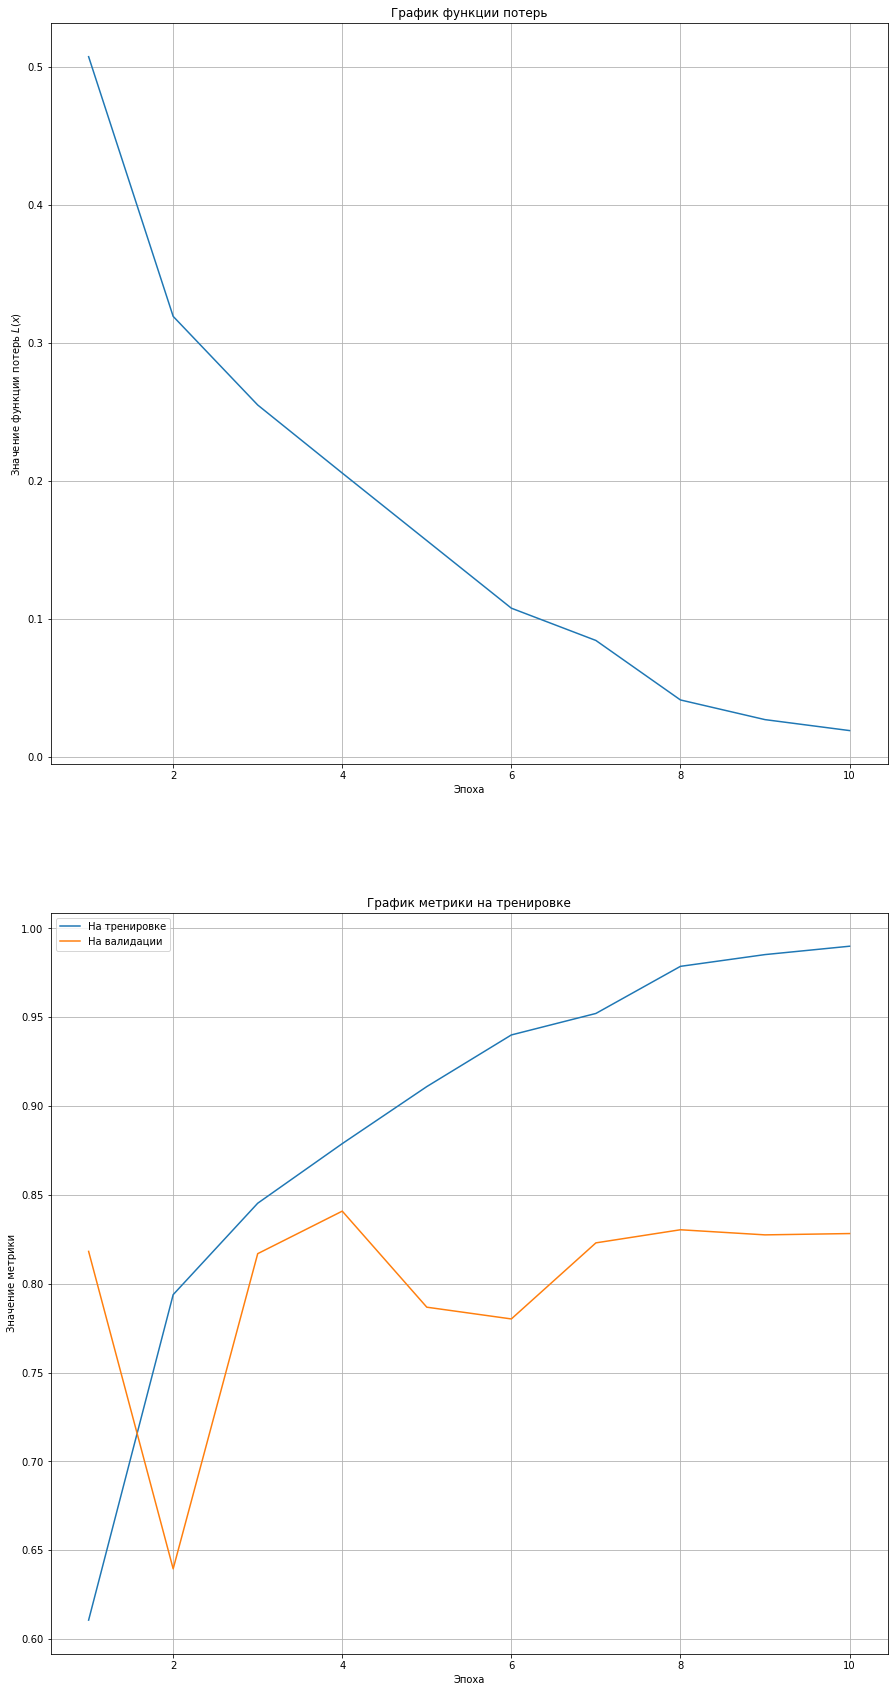

In [25]:
# Zeroes vectors

lstm_hid_layer_size = 60
layers_count = 1
drop_p = 0.2


model = LSTMPredictorEmbd(emb_tensor_zeros, lstm_hid_layer_size, layers_count, 
                          dropout_p=drop_p, bidirectional=True)

optimizer = optim.Adagrad(model.parameters(), lr=1e-1)

loss = torch.nn.BCELoss()

plot_results(*train_model(model, train_loader, val_loader, loss, metrics.f1_score, optimizer))

Epoch #1 -> Validation metric: 0.69818, Train metric: 0.51065, Loss value: 0.53139
Epoch #2 -> Validation metric: 0.68529, Train metric: 0.7867, Loss value: 0.32384
Epoch #3 -> Validation metric: 0.79542, Train metric: 0.82932, Loss value: 0.27189
Epoch #4 -> Validation metric: 0.83871, Train metric: 0.87486, Loss value: 0.21199
Epoch #5 -> Validation metric: 0.84129, Train metric: 0.90323, Loss value: 0.16573
Epoch #6 -> Validation metric: 0.83686, Train metric: 0.93128, Loss value: 0.11799
Epoch #7 -> Validation metric: 0.84627, Train metric: 0.95892, Loss value: 0.07061
Epoch #8 -> Validation metric: 0.83333, Train metric: 0.97677, Loss value: 0.04024
Epoch #9 -> Validation metric: 0.82263, Train metric: 0.98316, Loss value: 0.02806
Epoch #10 -> Validation metric: 0.83958, Train metric: 0.99098, Loss value: 0.01707


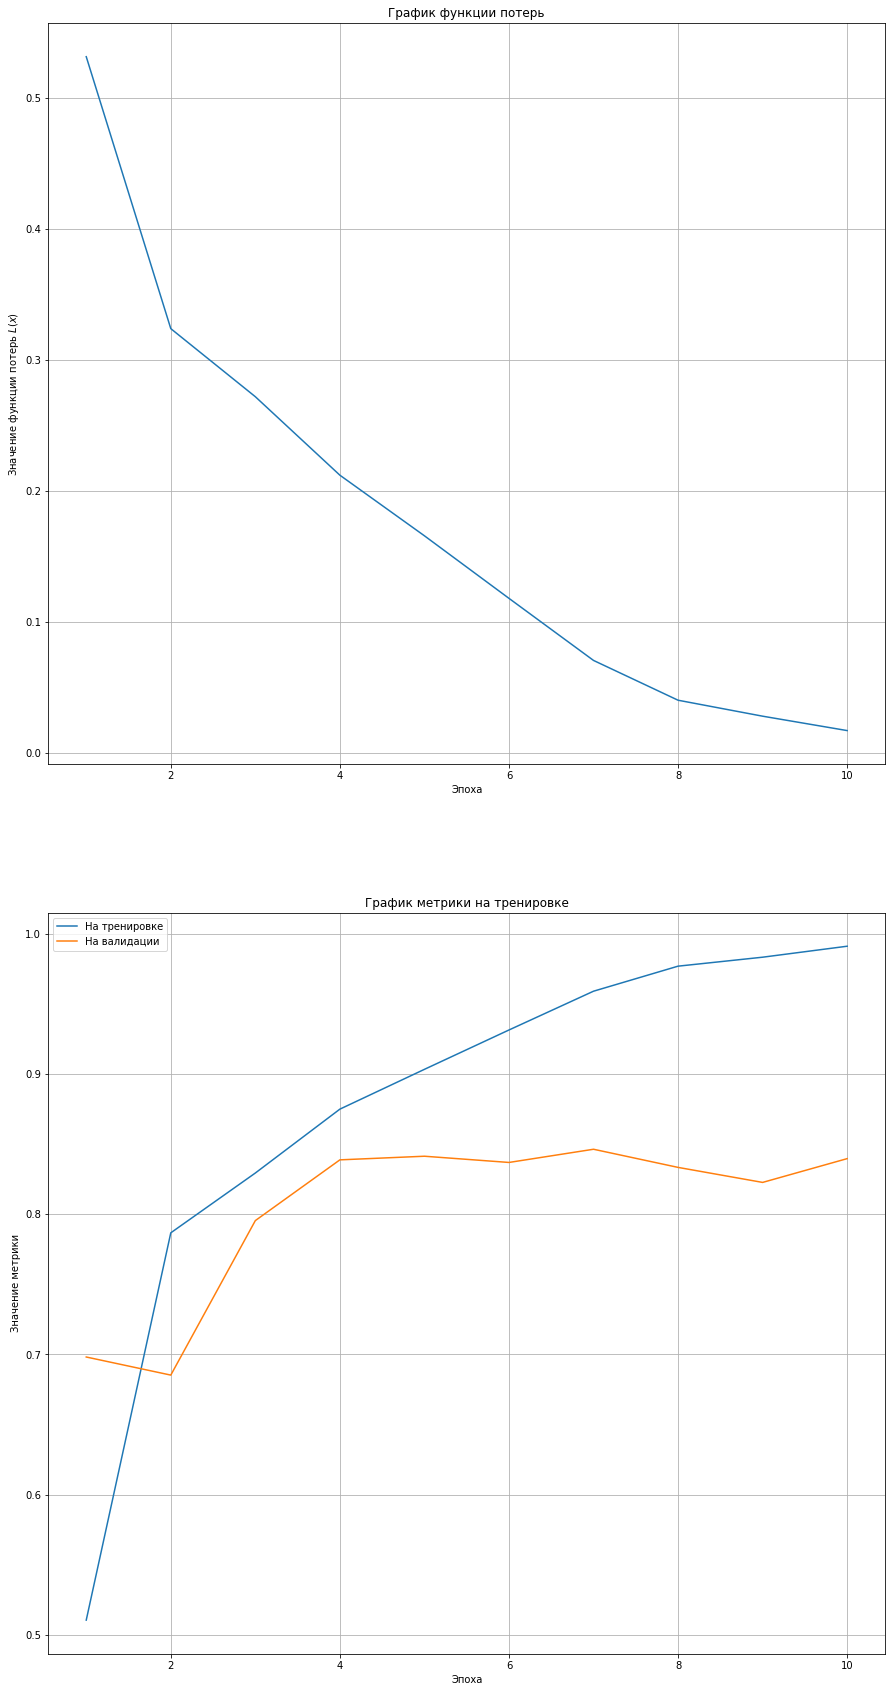

In [26]:
# Random vectors

lstm_hid_layer_size = 60
layers_count = 1
drop_p = 0.2


model = LSTMPredictorEmbd(emb_tensor_rnd, lstm_hid_layer_size, layers_count, 
                          dropout_p=drop_p, bidirectional=True)

optimizer = optim.Adagrad(model.parameters(), lr=1e-1)

loss = torch.nn.BCELoss()

plot_results(*train_model(model, train_loader, val_loader, loss, metrics.f1_score, optimizer))

Отсюда можно сделать вывод, что модель при использовании случайных векторов обучается более стабильно, чем использующая нули, поэтому дальше будем работать с embd случайных векторов

Epoch #1 -> Validation metric: 0.45714, Train metric: 0.48884, Loss value: 0.60552
Epoch #2 -> Validation metric: 0.78425, Train metric: 0.66449, Loss value: 0.45412
Epoch #3 -> Validation metric: 0.69835, Train metric: 0.72846, Loss value: 0.39811
Epoch #4 -> Validation metric: 0.83333, Train metric: 0.75835, Loss value: 0.35359
Epoch #5 -> Validation metric: 0.75393, Train metric: 0.80201, Loss value: 0.31675
Epoch #6 -> Validation metric: 0.8, Train metric: 0.81985, Loss value: 0.2897
Epoch #7 -> Validation metric: 0.69982, Train metric: 0.83761, Loss value: 0.26731
Epoch #8 -> Validation metric: 0.77834, Train metric: 0.8404, Loss value: 0.25237
Epoch #9 -> Validation metric: 0.80386, Train metric: 0.85836, Loss value: 0.23877
Epoch #10 -> Validation metric: 0.825, Train metric: 0.86248, Loss value: 0.23089


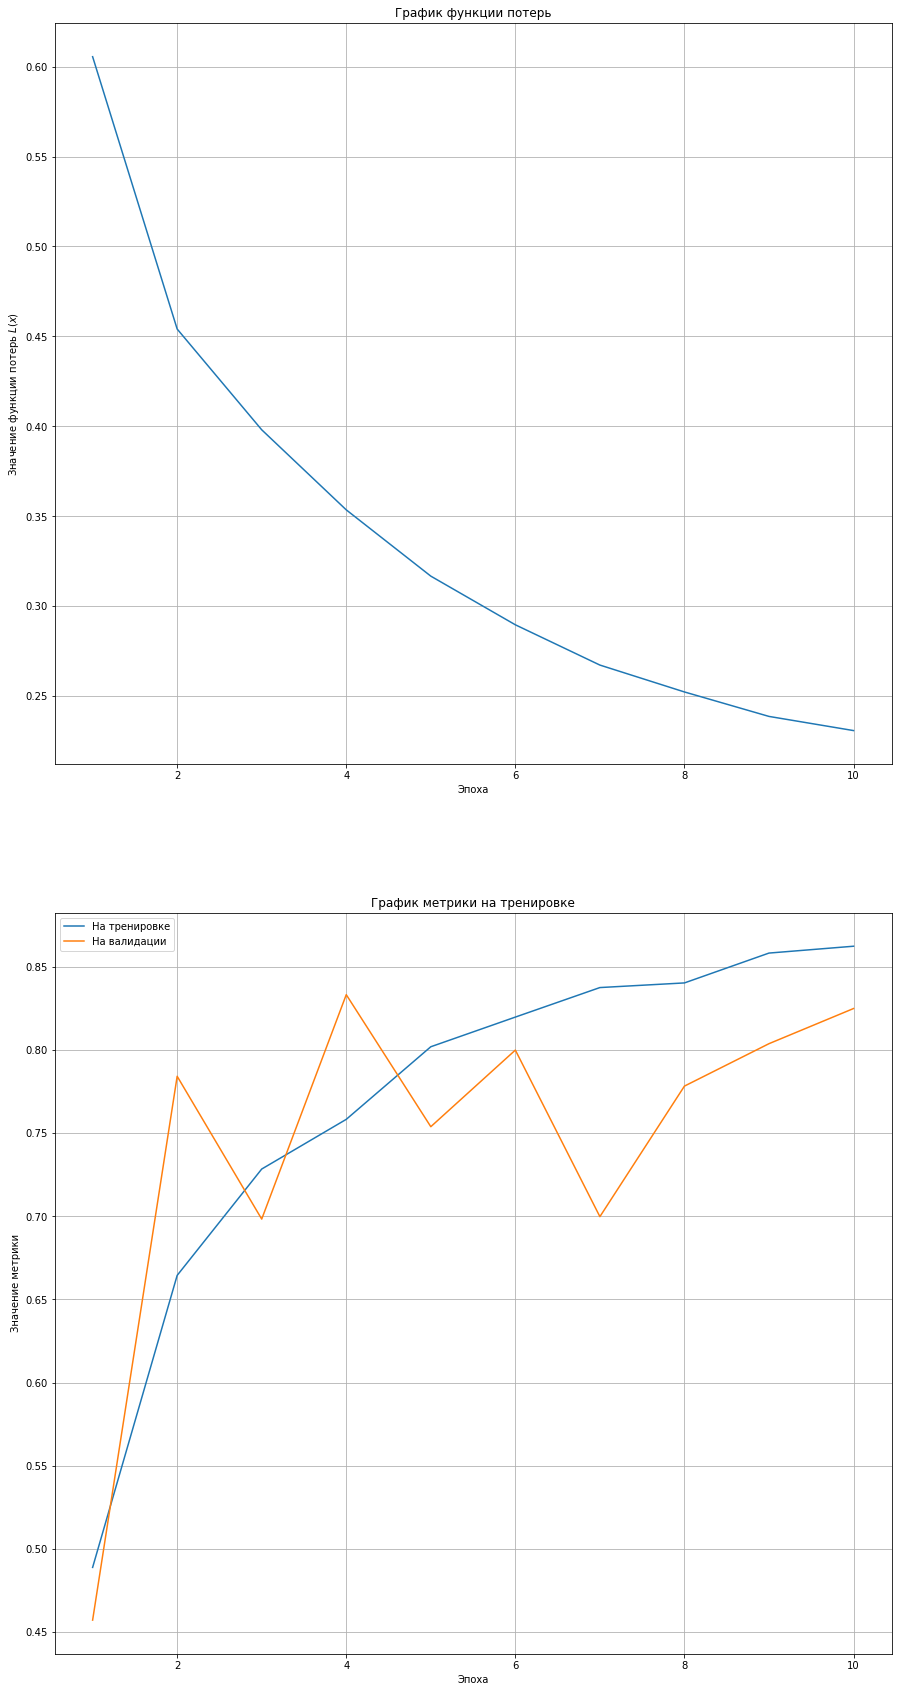

In [27]:
lstm_hid_layer_size = 120
layers_count = 3
drop_p = 0.2
l_r = 0.6e-1


best_model = LSTMPredictorEmbd(emb_tensor_rnd, lstm_hid_layer_size, layers_count, 
                               dropout_p=drop_p, bidirectional=True)

optimizer = optim.Adagrad(best_model.parameters(), lr=l_r)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

loss = torch.nn.BCELoss()

plot_results(*train_model(best_model, train_loader, val_loader, loss, metrics.f1_score, optimizer,
                          scheduler=scheduler, threshold=0.78))

Попробуем разрешить сети изменять вектора слов, но выставим для них маленькую скорость изменения. В ячейках ниже представлены лучшие результаты, которые мне удалось достичь для LSTM моделей

Epoch #1 -> Validation metric: 0.80328, Train metric: 0.50204, Loss value: 0.52222
Epoch #2 -> Validation metric: 0.79054, Train metric: 0.75666, Loss value: 0.3219
Epoch #3 -> Validation metric: 0.80929, Train metric: 0.81422, Loss value: 0.26832
Epoch #4 -> Validation metric: 0.81686, Train metric: 0.84533, Loss value: 0.22199
Epoch #5 -> Validation metric: 0.82889, Train metric: 0.87907, Loss value: 0.18527
Epoch #6 -> Validation metric: 0.82148, Train metric: 0.89449, Loss value: 0.15372
Epoch #7 -> Validation metric: 0.84226, Train metric: 0.92455, Loss value: 0.12089
Epoch #8 -> Validation metric: 0.84831, Train metric: 0.93895, Loss value: 0.09819
Epoch #9 -> Validation metric: 0.82934, Train metric: 0.95421, Loss value: 0.07818
Epoch #10 -> Validation metric: 0.83434, Train metric: 0.96106, Loss value: 0.06484


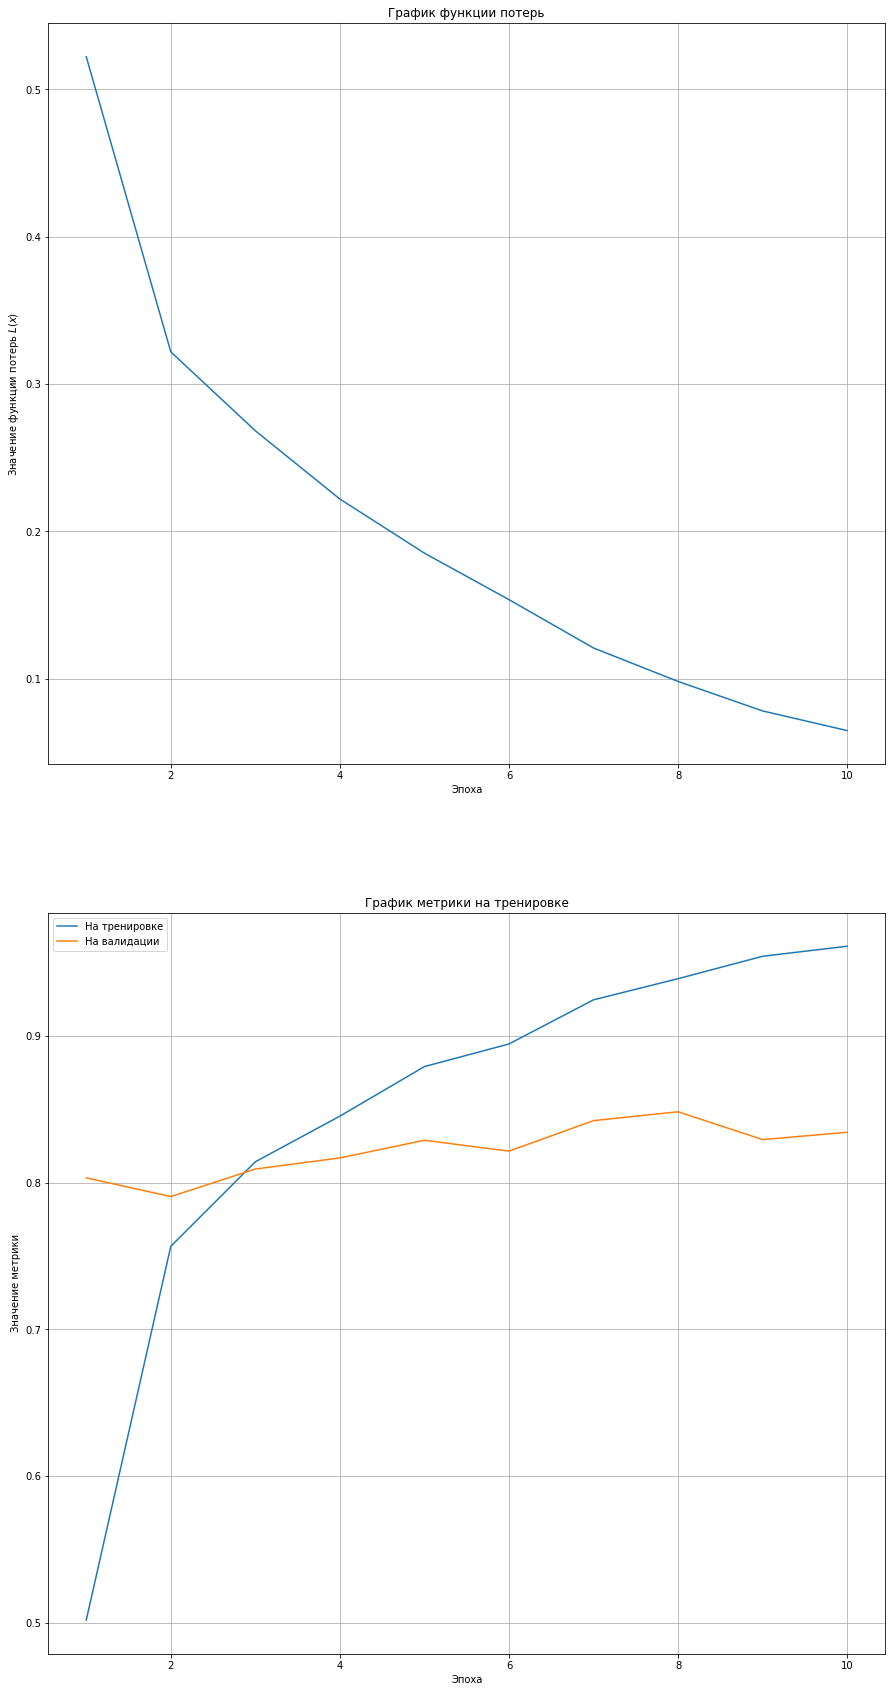

In [28]:
lstm_hid_layer_size = 50
layers_count = 1
drop_p = 0.6

net_l_r = 1e-1
word_vec_l_r = 1e-7


model = LSTMPredictorEmbd(emb_tensor_rnd, lstm_hid_layer_size, layers_count, 
                          dropout_p=drop_p, bidirectional=True, freeze_emb=False)

model_params = [i[1] for i in model.named_parameters() if 'emb' not in i[0]]

optimizer = optim.Adagrad([{'params': model_params}, {'params': model.emb.parameters()}])
optimizer.param_groups[0]['lr'] = net_l_r
optimizer.param_groups[1]['lr'] = word_vec_l_r

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

loss = torch.nn.BCELoss()

plot_results(*train_model(model, train_loader, val_loader, loss, metrics.f1_score, optimizer,
                          scheduler=scheduler, threshold=0.85))

### LSTM + FC

Попробуем добавить сети полносвязные слои, которые она сможет настраивать, а вот вектора слов запретим изменять

In [29]:
class LSTMPredictorEmbdFC(nn.Module):
    def __init__(self, word_emb: torch.Tensor, lstm_hid_layer_size: int, fc_hid_size: int, fc_layer_count: int=3, 
                 layers_count: int = 1, dropout_p: float = 0.5, bidirectional: bool = False, freeze_emb: bool=True):
        super().__init__()
        
        self.bidirectional = bidirectional
        self.emb = nn.Embedding.from_pretrained(word_emb, freeze=freeze_emb)
        
        self.lin_layers = [nn.Linear(self.emb.embedding_dim, fc_hid_size)] + \
                          [nn.Linear(fc_hid_size, fc_hid_size) for i in range(fc_layer_count - 1)]
        
        self.lstm = nn.LSTM(fc_hid_size, lstm_hid_layer_size, layers_count, 
                            bidirectional=bidirectional, batch_first=True)
        
        self.fc = nn.Linear(2 * lstm_hid_layer_size if bidirectional else lstm_hid_layer_size, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_p)
        
        
    def forward(self, x_batch, seq_len):
        embeded = self.emb(x_batch)
        
        
        fc_out = embeded
        for layer in self.lin_layers:
            fc_out = layer(fc_out)
        
        
        packed = nn.utils.rnn.pack_padded_sequence(fc_out, seq_len, batch_first=True, enforce_sorted=False)
        
        _, (h, c) = self.lstm(packed)
        # Prediction on last word
        
        h_con = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1) if self.bidirectional else h[-1]
        
        drop_pred = self.dropout(h_con)
        
        pred = self.fc(drop_pred) 
        
        return self.sigmoid(pred)

Epoch #1 -> Validation metric: 0.55172, Train metric: 0.42379, Loss value: 0.58902
Epoch #2 -> Validation metric: 0.55172, Train metric: 0.52879, Loss value: 0.54825
Epoch #3 -> Validation metric: 0.55172, Train metric: 0.53005, Loss value: 0.54391
Epoch #4 -> Validation metric: 0.53498, Train metric: 0.53159, Loss value: 0.54304
Epoch #5 -> Validation metric: 0.55285, Train metric: 0.52685, Loss value: 0.54137
Epoch #6 -> Validation metric: 0.55172, Train metric: 0.52693, Loss value: 0.53819
Epoch #7 -> Validation metric: 0.55172, Train metric: 0.5344, Loss value: 0.5391
Epoch #8 -> Validation metric: 0.55172, Train metric: 0.53085, Loss value: 0.53769
Epoch #9 -> Validation metric: 0.55172, Train metric: 0.53314, Loss value: 0.53833
Epoch #10 -> Validation metric: 0.55172, Train metric: 0.53139, Loss value: 0.53632


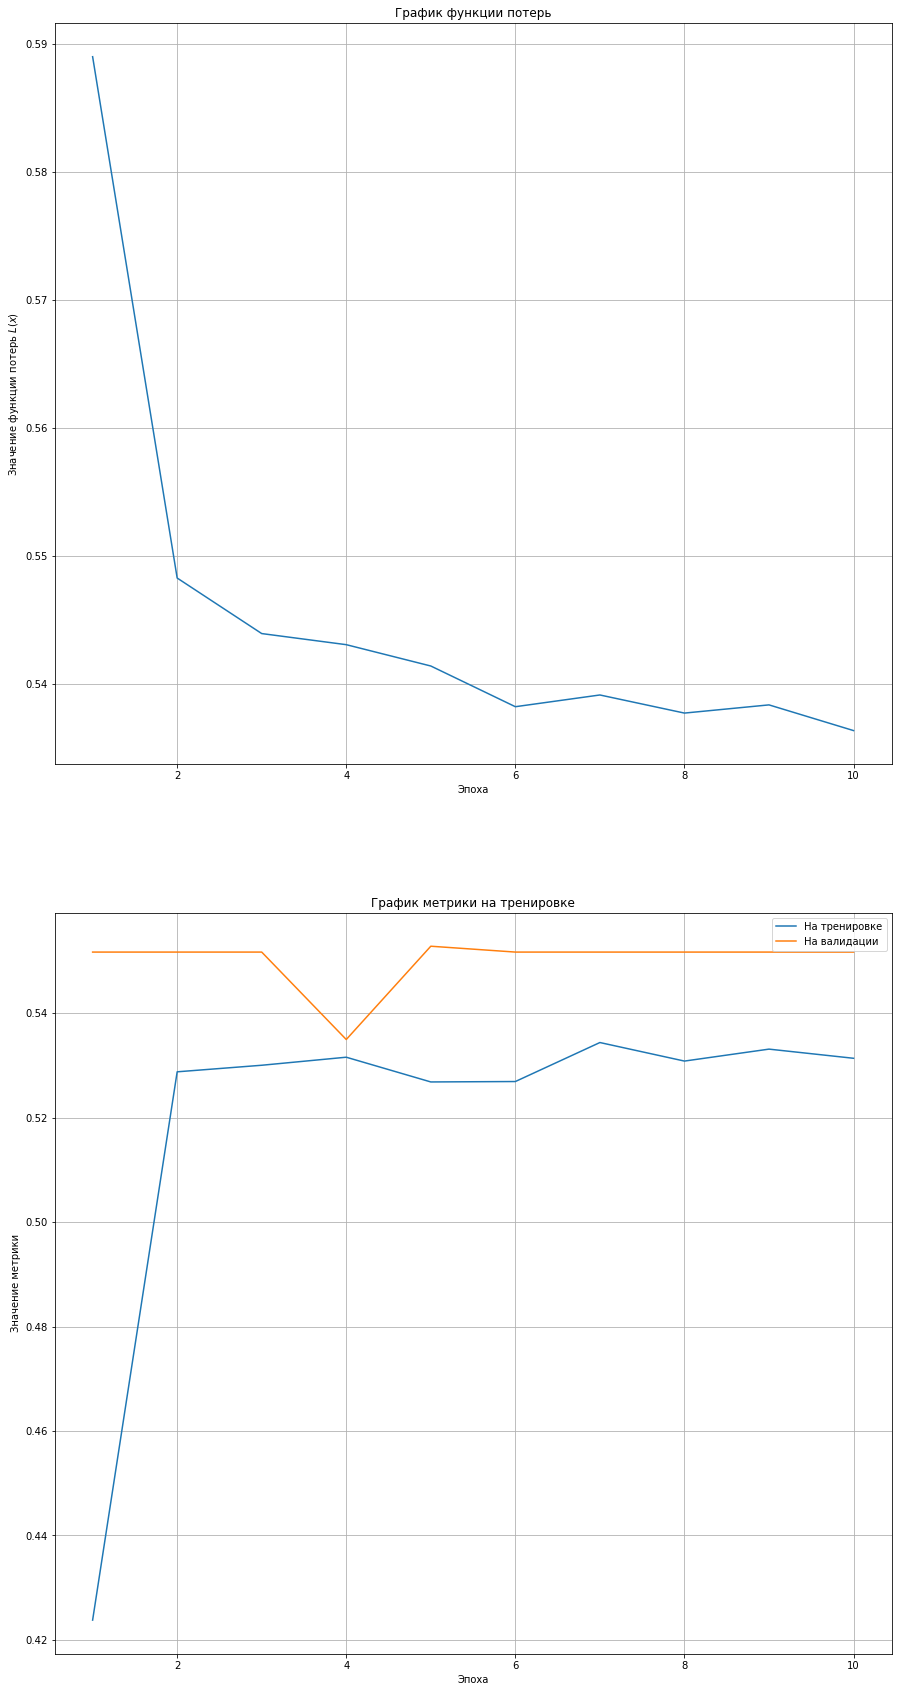

In [30]:
lstm_hid_layer_size = 50
layers_count = 2
fc_layer_size = 30
fc_layer_count = 3
drop_p = 0.6
l_r = 1e-2


model = LSTMPredictorEmbdFC(emb_tensor_rnd, lstm_hid_layer_size, fc_hid_size=fc_layer_size, fc_layer_count=fc_layer_count,
                            layers_count=layers_count, dropout_p=drop_p, bidirectional=True, freeze_emb=True)

optimizer = optim.Adagrad(model.parameters(), lr=l_r)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

loss = torch.nn.BCELoss()

plot_results(*train_model(model, train_loader, val_loader, loss, metrics.f1_score, optimizer,
                          scheduler=scheduler, threshold=0.78))

### Замена на рекуррентную сеть

Попробуем заменить LSTM на обычную рекуррентную сеть, тем самым упростив модель

In [31]:
class RNNPredictorEmbd(nn.Module):
    def __init__(self, word_emb: torch.Tensor, rnn_hid_layer_size: int, layers_count:int = 1, 
                 dropout_p: float = 0.5, bidirectional: bool = False):
        super().__init__()
        
        self.bidirectional = bidirectional
        self.emb = nn.Embedding.from_pretrained(word_emb)
        
        self.rnn = nn.RNN(self.emb.embedding_dim, rnn_hid_layer_size, layers_count, 
                          bidirectional=bidirectional, batch_first=True)
        
        self.fc = nn.Linear(2 * rnn_hid_layer_size if bidirectional else rnn_hid_layer_size, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_p)
        
        
    def forward(self, x_batch, seq_len):
        embeded = self.emb(x_batch)
        
        packed = nn.utils.rnn.pack_padded_sequence(embeded, seq_len, batch_first=True, enforce_sorted=False)
        
        _, h = self.rnn(packed)
        # Prediction on last word
        
        h_con = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1) if self.bidirectional else h[-1]
        
        drop_pred = self.dropout(h_con)
        
        pred = self.fc(drop_pred) 
        
        return self.sigmoid(pred)

Epoch #1 -> Validation metric: 0.60558, Train metric: 0.55782, Loss value: 0.48796
Epoch #2 -> Validation metric: 0.72987, Train metric: 0.76554, Loss value: 0.34464
Epoch #3 -> Validation metric: 0.73665, Train metric: 0.80024, Loss value: 0.30612
Epoch #4 -> Validation metric: 0.84308, Train metric: 0.81217, Loss value: 0.28706
Epoch #5 -> Validation metric: 0.84067, Train metric: 0.82539, Loss value: 0.27023
Epoch #6 -> Validation metric: 0.82683, Train metric: 0.83946, Loss value: 0.25659
Epoch #7 -> Validation metric: 0.77211, Train metric: 0.84138, Loss value: 0.24578
Epoch #8 -> Validation metric: 0.82995, Train metric: 0.85286, Loss value: 0.23572
Epoch #9 -> Validation metric: 0.80132, Train metric: 0.85975, Loss value: 0.2255
Epoch #10 -> Validation metric: 0.83851, Train metric: 0.86116, Loss value: 0.22353


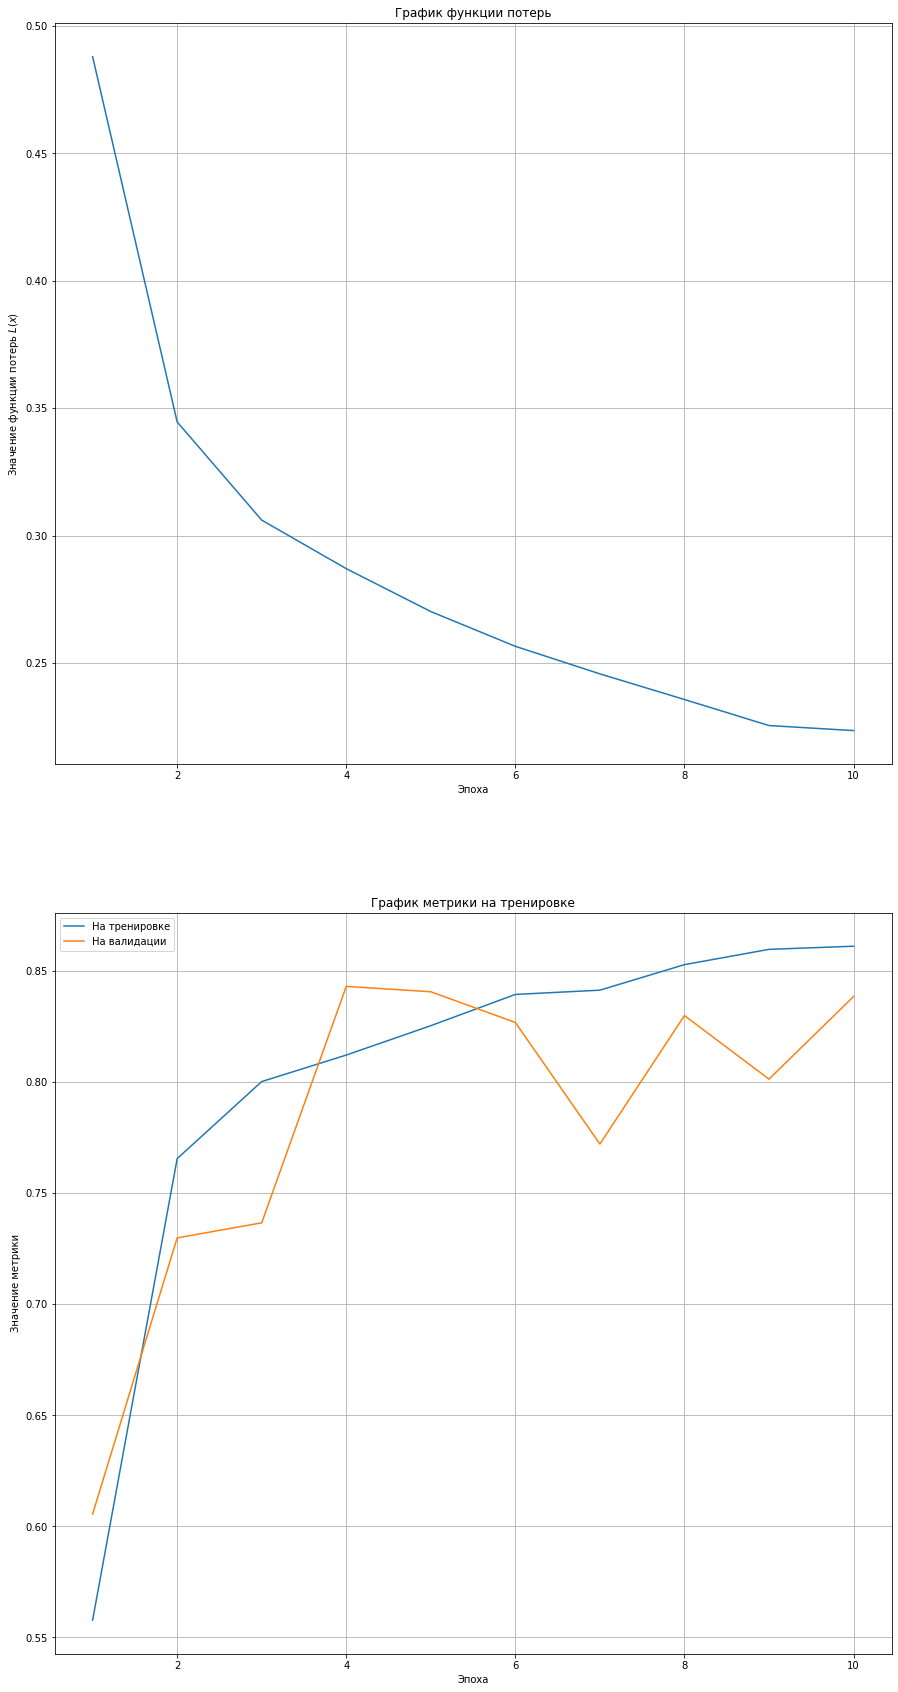

In [32]:
rnn_hid_layer_size = 60
layers_count = 1
drop_p = 0.6
l_r = 1e-2


model = RNNPredictorEmbd(emb_tensor_rnd, rnn_hid_layer_size, layers_count, 
                         dropout_p=drop_p, bidirectional=True)

optimizer = optim.Adagrad(model.parameters(), lr=l_r)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

loss = torch.nn.BCELoss()

plot_results(*train_model(model, train_loader, val_loader, loss, metrics.f1_score, optimizer,
                          scheduler=scheduler))

Как видно рекуррентная сеть также переобучается

### Convolutional net

Попробуем использовать свёрточную нейронную сеть. Данный метод взят из статьи: *A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification* **Ye Zhang, Byron Wallace**


In [33]:
class CNNEmb(nn.Module):
    def __init__(self, pretrained_emb: torch.Tensor, conv_size: list, channels_count: int=2, freeze_emb=True):
        """Implementing a convolution neural network for sentence classification
           Original article: https://arxiv.org/abs/1510.03820
           
           Args:
               pretrained_emb: Torch tensor of vectors of words
               conv_size: list of integers, it contains sizes for convolutional 
                          filters(length of words for analysis)
               
        """
        super().__init__()
        # Pretrained embeddings
        self.input_layer = nn.Embedding.from_pretrained(pretrained_emb, freeze=freeze_emb)
        # Convolutional layers
        self.conv_layers = [nn.Conv2d(in_channels=1, out_channels=channels_count, kernel_size=(height, pretrained_emb.shape[1]))
                            for height in conv_size]
        # Activation function
        self.activ = [nn.ReLU() for _ in range(len(self.conv_layers))]
        # Fully connected layer for extracting result
        self.fc = nn.Linear(len(conv_size) * channels_count, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X, *args):
        embedded = self.input_layer(X)
        # Adding extra dimension for channels
        embedded = torch.unsqueeze(embedded, 1)
        # List for saving results of different convolutional layers
        conv_data_lst = list()

        for ind in range(len(self.conv_layers)):
            conv = self.conv_layers[ind](embedded)
            # Applying activation
            actv = self.activ[ind](conv)
            
            conv_data_lst.append(torch.amax(actv, 2))
            
        # Concatenating results from convolutional layers
        concat_data = torch.squeeze(torch.concat(conv_data_lst, 1), 2)
        
        pred = self.fc(concat_data)
        
        return self.sigmoid(pred)

Epoch #1 -> Validation metric: 0.0, Train metric: 0.0171, Loss value: 0.68165
Epoch #2 -> Validation metric: 0.05618, Train metric: 0.02114, Loss value: 0.66846
Epoch #3 -> Validation metric: 0.01719, Train metric: 0.04071, Loss value: 0.66443
Epoch #4 -> Validation metric: 0.05618, Train metric: 0.04665, Loss value: 0.66165
Epoch #5 -> Validation metric: 0.01719, Train metric: 0.06373, Loss value: 0.66096
Epoch #6 -> Validation metric: 0.03409, Train metric: 0.05411, Loss value: 0.65939
Epoch #7 -> Validation metric: 0.03409, Train metric: 0.06549, Loss value: 0.65924
Epoch #8 -> Validation metric: 0.03409, Train metric: 0.06735, Loss value: 0.65887
Epoch #9 -> Validation metric: 0.03409, Train metric: 0.06455, Loss value: 0.65817
Epoch #10 -> Validation metric: 0.0452, Train metric: 0.06735, Loss value: 0.65847


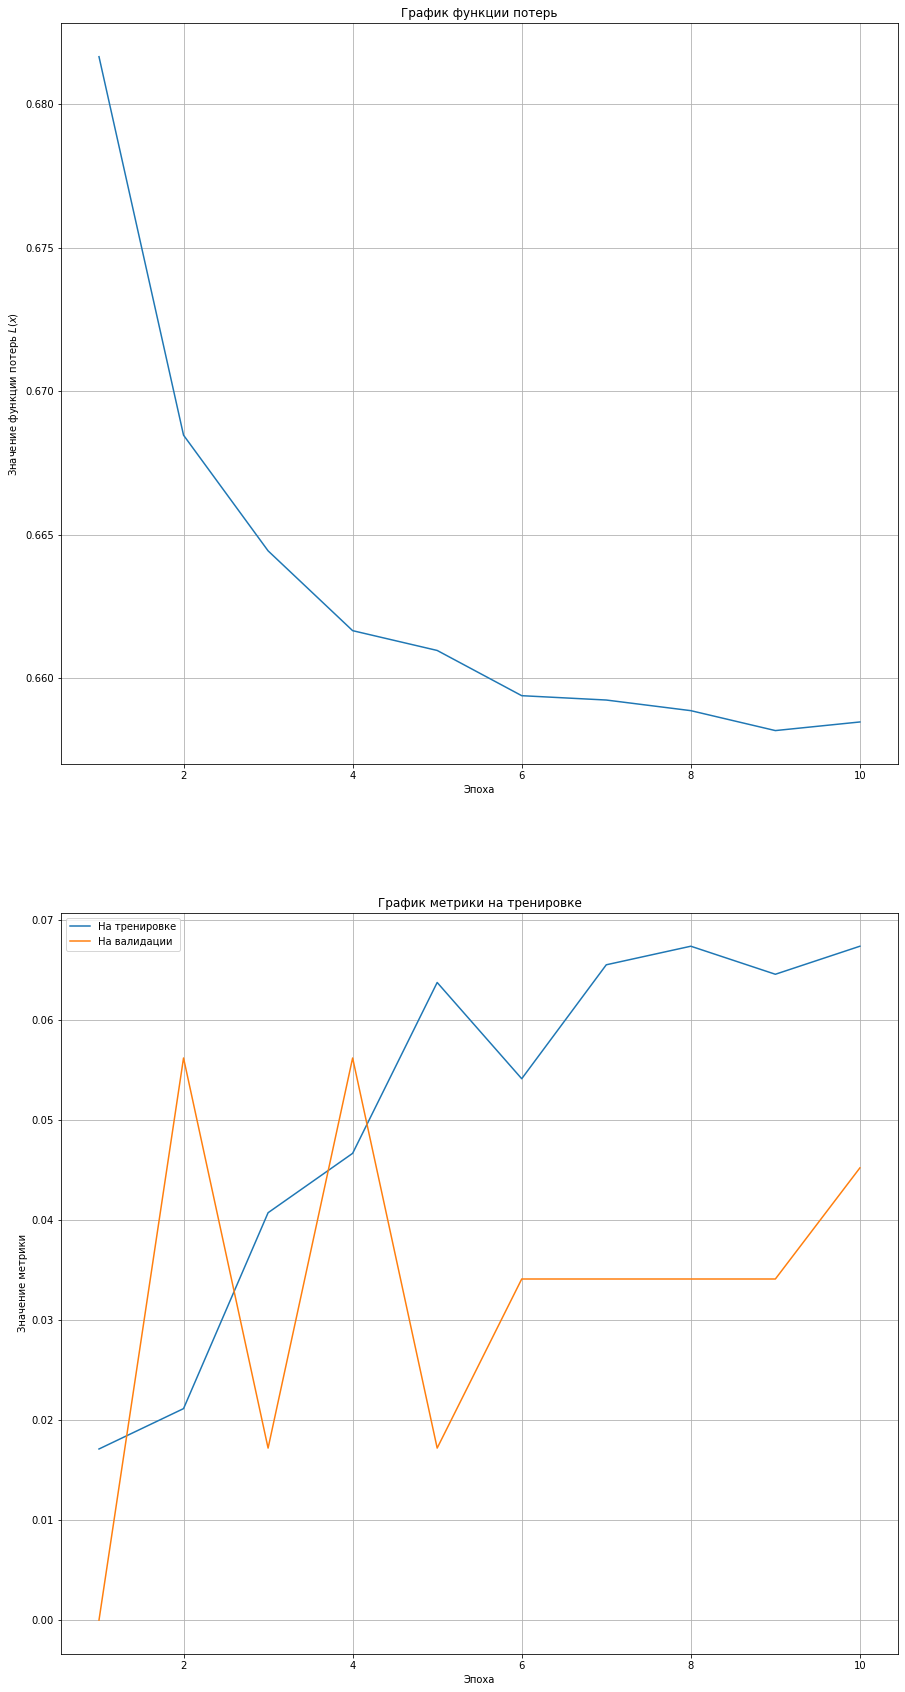

In [34]:
l_r = 0.5


model = CNNEmb(emb_tensor_rnd, conv_size=[2, 3, 4, 5, 6, 7], channels_count=3)

loss = nn.BCELoss()
optimizer = optim.Adagrad(model.parameters(), lr=l_r)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


plot_results(*train_model(model, train_loader, val_loader, loss, metrics.f1_score, optimizer,
                          scheduler=scheduler, threshold=0.78))

Такая сеть получается слабее рекуррентной и всё равно переобучается

### Conv + FC

Добавим после свёрточных слоёв полносвязные слои

In [35]:
class CNNEmbExt(nn.Module):
    def __init__(self, pretrained_emb: torch.Tensor, conv_size: list, channels_count: int=2, fc_hid=30, freeze_emb=True):
        """Implementing a convolution neural network for sentence classification
           Original article: https://arxiv.org/abs/1510.03820
           
           Args:
               pretrained_emb: Torch tensor of vectors of words
               conv_size: list of integers, it contains sizes for convolutional 
                          filters(length of words for analysis)
               
        """
        super().__init__()
        # Pretrained embeddings
        self.input_layer = nn.Embedding.from_pretrained(pretrained_emb, freeze=freeze_emb)
        # Convolutional layers
        self.conv_layers = [nn.Conv2d(in_channels=1, out_channels=channels_count, kernel_size=(height, pretrained_emb.shape[1]))
                            for height in conv_size]
        # Activation function
        self.activ = [nn.ReLU() for _ in range(len(self.conv_layers))]
        # Fully connected net
        self.fc = nn.Sequential(
            nn.Linear(len(conv_size) * channels_count, fc_hid),
            nn.ReLU(),
            nn.BatchNorm1d(fc_hid),
            
            nn.Linear(fc_hid, fc_hid),
            nn.ReLU(),
            nn.BatchNorm1d(fc_hid),
            
            nn.Dropout(0.3),
            
            nn.Linear(fc_hid, fc_hid),
            nn.ReLU(),
            nn.BatchNorm1d(fc_hid),
            
            nn.Linear(fc_hid, 1),            
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X, *args):
        embedded = self.input_layer(X)
        # Adding extra dimension for channels
        embedded = torch.unsqueeze(embedded, 1)

        conv_data_lst = list()

        for ind in range(len(self.conv_layers)):
            conv = self.conv_layers[ind](embedded)
            # Applying activation
            actv = self.activ[ind](conv)
            
            conv_data_lst.append(torch.amax(actv, 2))
            
        # Concating results from convolution layers
        concat_data = torch.squeeze(torch.concat(conv_data_lst, 1), 2)
        
        pred = self.fc(concat_data)
        
        return self.sigmoid(pred)

Epoch #1 -> Validation metric: 0.0, Train metric: 0.02099, Loss value: 0.69989
Epoch #2 -> Validation metric: 0.0, Train metric: 0.01416, Loss value: 0.65008
Epoch #3 -> Validation metric: 0.0, Train metric: 0.00407, Loss value: 0.63416
Epoch #4 -> Validation metric: 0.29647, Train metric: 0.07108, Loss value: 0.62531
Epoch #5 -> Validation metric: 0.04507, Train metric: 0.12559, Loss value: 0.62244
Epoch #6 -> Validation metric: 0.16667, Train metric: 0.21114, Loss value: 0.61668
Epoch #7 -> Validation metric: 0.0, Train metric: 0.23997, Loss value: 0.62023
Epoch #8 -> Validation metric: 0.07222, Train metric: 0.22574, Loss value: 0.61934
Epoch #9 -> Validation metric: 0.1671, Train metric: 0.20439, Loss value: 0.61461
Epoch #10 -> Validation metric: 0.08287, Train metric: 0.23333, Loss value: 0.61627


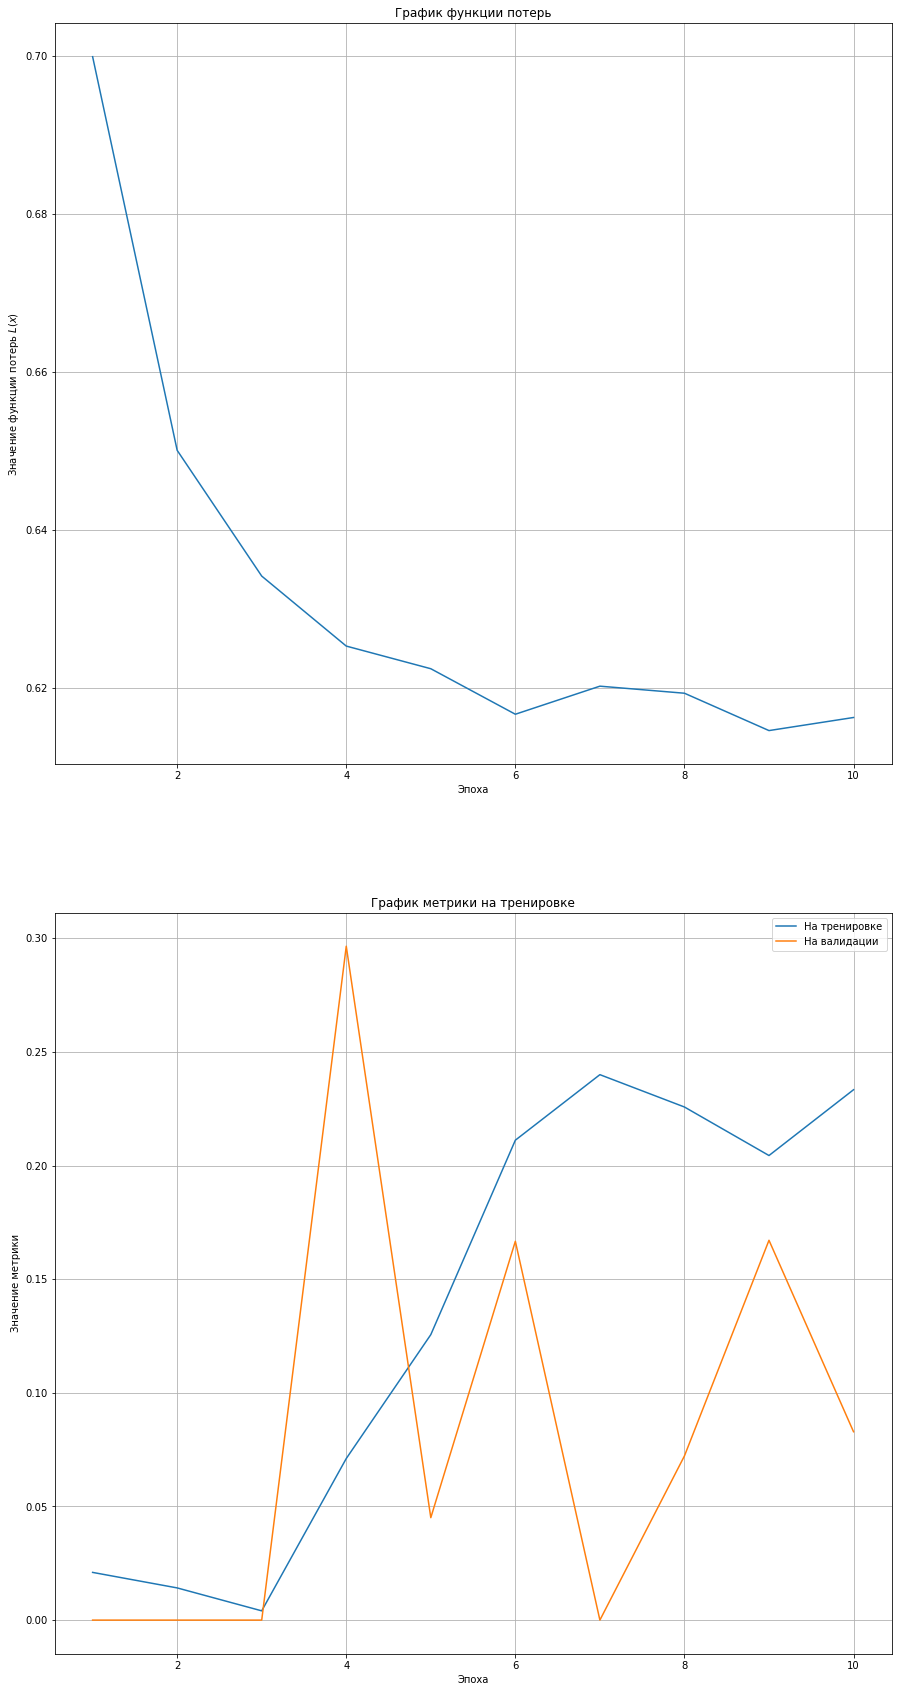

In [36]:
l_r = 0.5

model = CNNEmbExt(emb_tensor_rnd, conv_size=[2, 3, 4, 5, 6, 7, 8], channels_count=3, fc_hid=10, freeze_emb=True)

loss = nn.BCELoss()
optimizer = optim.Adagrad(model.parameters(), lr=l_r, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


plot_results(*train_model(model, train_loader, val_loader, loss, metrics.f1_score, optimizer,
                          scheduler=scheduler, threshold=0.78))

## Validation

Проверим качество полученных моделей на валидационной выборке, которую мы отложили в начале. Будем использовать модели с наивысшими показателями метрики

Подготовим словари и обучим модели на всей обучающей выборке

In [37]:
val_loader = DataLoader(TextDataset(val_ds, train_vocabulary), batch_size=32, shuffle=False)

In [38]:
compute_metric(best_model, val_loader, metrics.f1_score, 0.6)

0.8252252252252251

In [39]:
test_ds_torch = TextDataset(test_data, train_vocabulary)
loader = DataLoader(test_ds_torch, shuffle=False)

In [40]:
threshold = 0.6

model.eval()
    
y_probs = np.array([])

for x, y, seq_len in loader:
    pred = model(x, seq_len).reshape(-1)

    y_probs = np.hstack((y_probs, pred.detach().numpy()))

# Convertion from probabilities to class labels
label_predictions = [1 if i >= threshold else 0 for i in y_probs]

In [41]:
test_data['is_fake'] = label_predictions

Сохраняем результаты

In [42]:
test_data.to_csv('predictions_nn.tsv', sep='\t', index=False)